In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from os.path import join
import os
import random
from functools import partial
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate, Activation
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.backend import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard,RemoteMonitor
import tensorflow as tf
import ntpath
K.clear_session()
K.set_image_dim_ordering('tf')

print(K.image_data_format())
smooth = 1e-12
num_examples = 0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


channels_last


In [2]:
import glob
image_size = 512
def load_files():
    global image_size
    global num_examples
    mask_images=[]
    ori_images = []

    mask_path = "unet_train/gt/*"
    masks = glob.glob(mask_path)
    print("Loading masks")
    for fl in masks:
        train_image = cv2.imread(fl)
        shape = train_image.shape
        #Supervisely gives 3 images in out and we need the mask only
        start = shape[1]//3
        start = start * 2
        end = shape[1]
        train_image = train_image[: , start:end]
        train_image = cv2.resize(train_image, (image_size, image_size))
        mask_images.append(train_image)
    orig_path = "unet_train/orig/*"
    orig = glob.glob(orig_path)
    print("loading original")
    for fl in orig:
        orig_images = cv2.imread(fl)
        orig_images = cv2.resize(orig_images, (image_size, image_size))
        ori_images.append(orig_images)
    masked = np.array(mask_images)
    origi = np.array(ori_images)
    num_examples = masked.shape[0]
    return masked, origi

masks, origi = load_files()

Loading masks
loading original


In [3]:
t_ori, v_ori , t_masks, v_masks = train_test_split(origi, masks, test_size=0.33, random_state=42)

In [4]:
print(t_ori.shape)
print(v_ori.shape)

v_masks.shape

(41, 512, 512, 3)
(21, 512, 512, 3)


(21, 512, 512, 3)

In [5]:
def get_unet(input_shape=(512, 512, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 512

    down0a = Conv2D(16, (3, 3), padding='same')(inputs)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    # 512

    cov10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0a)

    model = Model(inputs=inputs, outputs=cov10)
    return model

In [6]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred)
    return loss

def unet_loss(y_true, y_pred):
    loss = bce_dice_loss(y_true,y_pred) - K.log(jaccard_coef(y_true,y_pred))
    return loss

In [11]:
class BatchGenerator:
    
    def __init__(self, size, n_cls, batch_size):
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_batch(self):
        global t_ori
        global t_masks
        while True:
            orig_btch = np.zeros((self.batch_size, self.size, self.size, 3))
            gt_btch = np.zeros((self.batch_size, self.size, self.size, 3))
            perm = np.arange(num_examples)
            np.random.shuffle(perm)
            some_masks = [t_masks[j] for j in perm]
            some_ori = [t_ori[j] for j in perm]
            for i in range(self.batch_size):
                orig_btch[i] = some_ori[i]
                gt_btch[i] = some_masks[i]
            yield orig_btch, gt_btch

In [12]:
class VBatchGenerator:
    
    def __init__(self, size, n_cls, batch_size):
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_batch(self):
        global v_masks
        global v_ori
        while True:
            origbatch = np.zeros((self.batch_size, self.size, self.size, 3))
            gtbatch = np.zeros((self.batch_size, self.size, self.size, 3))
            perm = np.arange(num_val)
            np.random.shuffle(perm)
            somev_masks = [v_masks[j] for j in perm]
            somev_ori = [v_ori[j] for j in perm]
            for i in range(self.batch_size):
                origbatch[i] = somev_ori[i]
                gtbatch[i] = somev_masks[i]
            yield origbatch, gtbatch

In [13]:
from time import time
num_examples = t_ori.shape[0]
num_val = v_ori.shape[0]
batch_size = 4
s_tr =np.floor(float(t_ori.shape[0]) / float(batch_size))
s_val =np.floor(float(v_ori.shape[0]) / float(batch_size))
train_batch_generator = BatchGenerator( image_size, 1, batch_size)
valid_batch_generator = VBatchGenerator(image_size, 1,batch_size)
size = image_size
n_cls = 1
model = get_unet()
model.compile(optimizer=Adam(lr=1e-4), loss=unet_loss, metrics=['acc'])
tensorboard = TensorBoard(log_dir="unetlog/", batch_size=4,write_graph=True)
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers=None),
             tensorboard]
model.fit_generator(train_batch_generator.get_batch(),steps_per_epoch=s_tr,epochs=20, callbacks=callbacks, validation_data=valid_batch_generator.get_batch(),validation_steps=s_val)

Epoch 1/20
10/10 [==============================] - 110s 11s/step - loss: 19.3616 - acc: 0.0045 - val_loss: 82.0147 - val_acc: 5.5288e-04
Epoch 2/20


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:588: UserWarning: Warning: could not reach RemoteMonitor root server at http://localhost:9000
  'root server at ' + str(self.root))


10/10 [==============================] - 109s 11s/step - loss: 2.5674 - acc: 3.6974e-04 - val_loss: 32.9777 - val_acc: 0.0022
Epoch 3/20
10/10 [==============================] - 107s 11s/step - loss: -12.3303 - acc: 0.0044 - val_loss: 74.7261 - val_acc: 2.6677e-04
Epoch 4/20
10/10 [==============================] - 108s 11s/step - loss: -30.1705 - acc: 0.0077 - val_loss: 27.0212 - val_acc: 7.2047e-04
Epoch 5/20
10/10 [==============================] - 109s 11s/step - loss: -41.3298 - acc: 0.0042 - val_loss: 30.8804 - val_acc: 0.0023
Epoch 6/20
10/10 [==============================] - 108s 11s/step - loss: -51.2560 - acc: 3.1484e-04 - val_loss: 18.6486 - val_acc: 0.0013
Epoch 7/20
10/10 [==============================] - 108s 11s/step - loss: -55.0297 - acc: 0.0041 - val_loss: -31.3900 - val_acc: 1.5653e-04
Epoch 8/20
10/10 [==============================] - 109s 11s/step - loss: -59.7159 - acc: 0.0041 - val_loss: -29.1677 - val_acc: 0.0013
Epoch 9/20
10/10 [============================

In [ ]:
train_batch_generator = BatchGenerator( 512, 1, 4)
w=train_batch_generator.get_batch()

In [ ]:
v_ori.shape

In [ ]:
lol = np.zeros((4,512,512, 3))
lil = np.zeros((4, 512, 512, 1))
perm = np.arange(v_masks.shape[0])
np.random.shuffle(perm)
li = [v_masks[j] for j in perm]
lo = [v_ori[j] for j in perm]

In [ ]:
lil[1] =li[1]

In [ ]:
lil.shape

In [ ]:
import numpy as np
myarray = np.asarray(v_masks)


In [ ]:
plt.imshow(myarray[1])
plt.show()

In [62]:
from importlib import reload
reload(K)
import h5py
model.save('accunet.h5')

Using TensorFlow backend.


In [72]:
train_image = cv2.imread("1398.png")
shape = train_image.shape
train_image = cv2.resize(train_image, (image_size, image_size))


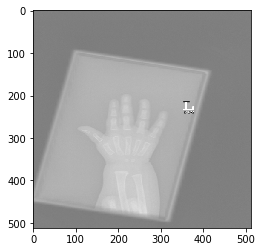

In [73]:
plt.imshow(train_image)
plt.show()

In [74]:
train_pic = np.array(train_image)
train_pic.shape

(512, 512, 3)

In [75]:
image = np.expand_dims(train_pic, axis=0)

In [76]:
image.shape

(1, 512, 512, 3)

In [77]:
mpo=model.predict(image)
#print(mpo)
mpo.shape

(1, 512, 512, 1)

In [78]:
mpo = mpo.reshape(512,512)

In [79]:
mpo.shape

(512, 512)

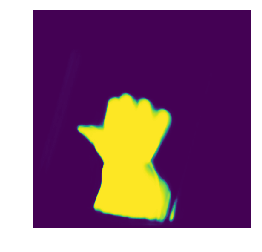

In [80]:
plt.axis('off')
plt.imshow(mpo)
#plt.savefig('output.png')
plt.show()

In [ ]:
hsv = cv2.cvtColor(mpo, cv2.COLOR_BGR2HSV)
# define range of blue color in HSV
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
    # Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)
    # Bitwise-AND mask and original image
res = cv2.bitwise_and(frame,frame, mask= mask)
    cv2.imshow('frame',frame)
    cv2.imshow('mask',mask)
    cv2.imshow('res',res)

In [ ]:
train_image = cv2.imread('1901.jpg')
shape = train_image.shape
#Supervisely gives 3 images in out and we need the mask onl
start = shape[1]//3
end = 2 * start
train_image = train_image[: , start:end]
train_image = cv2.resize(train_image, (image_size, image_size))
print(len(train_image.shape))

In [ ]:
train_image.shape

In [ ]:
train_image = cv2.imread("1903.jpg")
shape = train_image.shape
train_image = cv2.resize(train_image, (image_size, image_size))
plt.axis('off')
plt.imshow(train_image)
plt.savefig('input.png')
plt.show()

In [ ]:

model = load_model('modeltr.h5', custom_objects={'jaccard_coef_int': jaccard_coef_int,'jaccard_coef_loss': jaccard_coef_loss})



In [ ]:
image_size =512
train_image = cv2.imread('testing/1384.png')
shape = train_image.shape
train_image = cv2.resize(train_image, (image_size, image_size))
train_pic = np.array(train_image)
image = np.expand_dims(train_pic, axis=0)

In [ ]:
image.shape


In [ ]:
g = model.predict(image)

In [ ]:
g.shape

In [ ]:
g = g.reshape(512,512,3)

In [ ]:
g.shape

In [ ]:
plt.imshow(g)

In [ ]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    return cv2.addWeighted(mask, 0.5, image, 0.5, 0.)

In [ ]:
import cv2
img= cv2.imread('train/boneage-training-dataset/1903.png')
img = cv2.resize(img, (512, 512))
image = np.expand_dims(img, axis=0)
g = model.predict(image)


In [ ]:
g.shape

In [ ]:
g.reshape(512,512,3)

In [ ]:
g.shape

In [ ]:
g.shape
largestCC = g == np.argmax(np.bincount(g.flat))

In [ ]:
plt.imshow(mask_overlay(img, (g > 0.5).astype(np.uint8)))

In [ ]:
plt.imshow(g)

In [ ]:
image = g.astype('uint')

In [ ]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    cv2.imshow("Biggest component", img2)
    cv2.waitKey()

In [ ]:
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat))
    return largestCC
a = getLargestCC(mpo)

In [ ]:
a=1-a
plt.imshow(a.astype(np.float32))

In [ ]:
g =g.reshape(512,512,3)

In [ ]:
g.dtype
a =np.finfo(np.float32).min

In [ ]:
g.dtype

In [ ]:
s_tr =np.floor(float(t_ori.shape[0]) / float(batch_size))
s_val =np.floor(float(v_ori.shape[0]) / float(batch_size))
print(s_tr)
print(s_val)

In [ ]:

ball_ycrcb_mint = np.array([0, 90, 100],np.uint8)
ball_ycrcb_maxt = np.array([25, 255, 255],np.uint8)
ball_ycrcb = cv2.inRange(gray_image, ball_ycrcb_mint, ball_ycrcb_maxt)
#cv2.imwrite('Photos/output2.jpg', ball_ycrcb) # Second image
areaArray = []
count = 1

contours, _ = cv2.findContours(ball_ycrcb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    areaArray.append(area)

#first sort the array by area
sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)

#find the nth largest contour [n-1][1], in this case 2
secondlargestcontour = sorteddata[1][1]

#draw it
x, y, w, h = cv2.boundingRect(secondlargestcontour)
cv2.drawContours(im, secondlargestcontour, -1, (255, 0, 0), 2)
cv2.rectangle(im, (x, y), (x+w, y+h), (0,255,0), 2)
cv2.imwrite('Photos/output3.jpg', im)

In [ ]:
plt.imshow(gray_image)

In [ ]:
ret, thresh = cv2.threshold(gray_image, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0,255,0), 3)


In [ ]:
a = cv2.imread('1903.png')
arr = np.uint8(image)


In [ ]:
arr.shape

In [ ]:
train_image = cv2.resize(a, (image_size, image_size))
train_image = np.expand_dims(train_image, axis=0)
dk=model.predict(train_image)

In [ ]:
a= np.uint8(dk*255)
a= a.reshape(512,512,3)

In [ ]:
plt.imshow(a)
gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

In [ ]:
#cleaning the image
p = cv2.imread('train/boneage-training-dataset/1384.png')
train_image = cv2.resize(p, (image_size, image_size))
train_image = np.expand_dims(train_image, axis=0)
dk=model.predict(train_image)
a= np.uint8(dk*255)
a= a.reshape(512,512,3)
gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
mask = np.ones((512,512), dtype="uint8") * 255

_, contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    if area < 90000:
        cv2.drawContours(mask, [c], -1, 0, -1)

image = cv2.bitwise_and(a, a, mask=mask)    
plt.imshow(image)


In [ ]:
ball_ycrcb_mint = np.array([0, 90, 100],np.uint8)
ball_ycrcb_maxt = np.array([25, 255, 255],np.uint8)
ball_ycrcb = cv2.inRange(im_ycrcb, ball_ycrcb_mint, ball_ycrcb_maxt)
#cv2.imwrite('Photos/output2.jpg', ball_ycrcb) # Second image
areaArray = []
count = 1

contours, _ = cv2.findContours(ball_ycrcb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    areaArray.append(area)

#first sort the array by area
sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)

#find the nth largest contour [n-1][1], in this case 2
secondlargestcontour = sorteddata[1][1]

#draw it
x, y, w, h = cv2.boundingRect(secondlargestcontour)
cv2.drawContours(im, secondlargestcontour, -1, (255, 0, 0), 2)
cv2.rectangle(im, (x, y), (x+w, y+h), (0,255,0), 2)

In [ ]:
new_img = np.zeros_like(arr)                                        # step 1
for val in np.unique(arr)[1:]:                                      # step 2
    mask = np.uint8(img == val)                                     # step 3
    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]  # step 4
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])      # step 5
    new_img[labels == largest_label] = val


In [ ]:
plt.imshow(image)
plt.show()
plt.imshow(p)
plt.show()

In [ ]:
d = model.predict(train_image)

In [ ]:
fig=plt.figure(figsize=(50, 50))
columns = 2
rows = 1
img = p
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.savefig('mamos.png')
fig.add_subplot(rows, columns, 2)
plt.imshow(a)
plt.title('image_test',fontsize=26)
plt.show()

In [ ]:
!ls    

In [ ]:
train_image = cv2.imread('1901.jpg')
shape = train_image.shape
        #Supervisely gives 3 images in out and we need the mask only
start = shape[1]//3
start = start * 2
end = shape[1]
train_image = train_image[: , start:end]
print(train_image.shape)

In [ ]:
gray=cv2.cvtColor(train_image,cv2.COLOR_BGR2GRAY)

(thresh, im_bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


In [ ]:
plt.imshow(im_bw)
plt.show()

In [ ]:
im_bw

In [ ]:
gray[500]

In [ ]:
a=cv2.imread('/home/ubuntu/Downloads/train_hq/0cdf5b5d0ce1_01.jpg')

In [ ]:
a.shape

In [ ]:
import imageio
gi = imageio.imread('/home/ubuntu/research/carvana/train_masks/0cdf5b5d0ce1_01_mask.gif')
gi.shape

In [ ]:
backtorgb = cv2.cvtColor(gi,cv2.COLOR_GRAY2RGB)
plt.imshow(backtorgb)
plt.show()

In [ ]:
thresh =127
im_bw = cv2.threshold(gi,thresh,255,cv2.THRESH_BINARY)[1]

In [ ]:
plt.imshow(im_bw)

In [ ]:
np.unique(thresh)